In [1]:
import casadi as ca
import numpy as np
import control
import matplotlib.pyplot as plt
import scipy.signal

# air data computer
def adc(VT, H):
    """
    Simple atmospheric model
    source: Aircraft Control and Simulation, Stevens and Lewis, pg. 634
    """
    R0 = 2.377e-3 # sea-level density
    TFAC = 1.0 - 0.703e-5*H
    T = ca.if_else(H > 35000, 390, 519.0 * TFAC) # temperature
    RHO = R0*TFAC**4.14
    AMACH = VT/ca.sqrt(1.4*1716.3*T)
    QBAR = 0.5*RHO*VT*VT
    return AMACH, QBAR

def transp(t, x, u):
    """
    A model of a medium-size transport aircraft, longitudinal dynamics.
    source: Aircraft Control and Simulation, Stevens and Lewis, pg. 182
    """
    S = 2170.0
    CBAR = 17.5
    MASS = 5.0E3
    IYY = 4.1E6
    TSTAT= 6.0E4
    DTDV = -38.0
    ZE = 2.0
    CDCLS = 0.042
    CLA = 0.085
    CMA = -0.022
    CMDE = -0.016
    CMQ = -16.0
    CMADOT = -6.0
    CLADOT = 0.0
    RTOD = 57.29578
    GD = 32.17
    
    def saturate(y, y_min, y_max):
        return ca.if_else(y < y_min, y_min, ca.if_else(y > y_max, y_max, y))
    
    # input
    THTL = saturate(u[0], 0, 1)
    ELEV = saturate(u[1], -30, 30)
    XCG = u[2]
    LAND = u[3]
    
    # state
    VT = x[0]
    ALPHA = RTOD*x[1]
    THETA = x[2]
    Q = x[3]
    H = x[4]
    P = x[5]

    MACH, QBAR = adc(VT, H)
    QS = QBAR*S
    SALP = ca.sin(x[1])
    CALP = ca.cos(x[1])
    GAM = THETA - x[1]
    SGAM = ca.sin(GAM)
    CGAM = ca.cos(GAM)
    CL0 = ca.if_else(LAND, 1.0, 0.20)
    CD0 = ca.if_else(LAND, 0.08, 0.016)
    CM0 = ca.if_else(LAND, -0.20, 0.05)
    DCDG = ca.if_else(LAND, 0.02, 0)
    DCMG = ca.if_else(LAND, -0.05, 0)
    
    THR = (TSTAT + VT*DTDV) * ca.if_else(THTL > 0, THTL, 0) # thrust
    CL = CL0 + CLA*ALPHA # nondim. lift
    CM = DCMG + CM0 + CMA*ALPHA + CMDE*ELEV + CL*(XCG - 0.25) # moment
    CD = DCDG + CD0 + CDCLS*CL*CL # drag polar
    
    # state equations
    xd = ca.SX.zeros(6)
    xd[0] = (THR*CALP - QS*CD)/MASS - GD*SGAM
    xd[1] = (-THR*SALP - QS*CL + MASS*(VT*Q + GD*CGAM))/(MASS*VT + QS*CLADOT)
    xd[2] = Q
    D = 0.5*CBAR*(CMQ*Q + CMADOT*xd[1])/VT # pitch damping
    xd[3] = (QS*CBAR*(CM + D) + THR*ZE)/IYY # Q-dot
    xd[4] = VT*SGAM # vertical speed
    xd[5] = VT*CGAM # horizontal speed
    
    return xd

In [2]:
def trim_level_flight(v, h, xcg, land):
    q = 0 # not rotating
    pos = 0 # position of aircraft
    def cost(x, v, h, xcg, land):
        throttle = x[0]
        elev = x[1]
        alpha = x[2]
        theta = alpha # level flight
        dx = transp(0, [v, alpha, theta, q, h, pos], [throttle, elev, xcg, land])
        J = ca.diag([1, 1, 1, 1, 1, 0])
        return ca.mtimes([dx.T, J, dx])
    #trim = scipy.optimize.minimize(cost, [0.5, 0, 0],
    #                               args=(v, h, xcg, land))
    
    x = ca.SX.sym('x', 3, 1)
    f = cost(x, v, h, xcg, land)
    nlp = {}                 # NLP declaration
    nlp['x']= x             # decision vars
    nlp['f'] = f             # objective
    nlp['g'] = []            # constraints

    # Create solver instance
    F = ca.nlpsol('F', 'ipopt', nlp, {'ipopt': {'print_level': 0}});

    # Solve the problem using a guess
    trim = F(x0=[0.5, 0, 0], lbx=[0, -30, -30], ubx=[1, 30, 30], ubg=0, lbg=0)
    throttle = trim['x'][0]
    elev = trim['x'][1]
    alpha = trim['x'][2]
    theta = alpha
    q = 0
    x0 = np.array([v, alpha, theta, q, h, pos])
    u0 = np.array([throttle, elev, xcg, land])
    if np.abs(float(trim['f'])) > 1e-10:
        raise RuntimeError('Trim failed')
    return {
        'x0': x0,
        'u0': u0,
        'res': trim
    }

trim_data = trim_level_flight(500, 100, 0.25, 0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

               t_proc [s]   t_wall [s]    n_eval
           F      0.00798       0.0105         1
       nlp_f     0.000108     0.000102        23
  nlp_grad_f      8.2e-05     7.98e-05        19
  nlp_hess_l      9.6e-05     9.51e-05        17


In [3]:
def linearize_at_operating_point(trim_data):
    x0 = trim_data['x0']
    u0 = trim_data['u0']
    trim_res  = trim_data['res']
    n_x = 6
    n_u = 4
    n_y = n_x
    x = ca.SX.sym('x', n_x, 1)
    u = ca.SX.sym('u', n_u, 1)
    A = ca.jacobian(transp(0, x, u), x)
    B = ca.jacobian(transp(0, x, u), u)
    C = np.eye(n_y)
    D = np.zeros((n_y, n_u))

    def eval_at_trim(A, x0, u0):
        return np.array(ca.DM(ca.substitute(A, ca.vertcat(x, u), ca.vertcat(x0, u0))))

    A0 = eval_at_trim(A, x0, u0)
    B0 = eval_at_trim(B, x0, u0)
    C0 = eval_at_trim(C, x0, u0)
    D0 = eval_at_trim(D, x0, u0)

    x_id = {'v': 0, 'alpha': 1, 'theta': 2, 'q': 3, 'h': 4, 'pos': 5}
    y_id = {'v': 0, 'alpha': 1, 'theta': 2, 'q': 3, 'h': 4, 'pos': 5}
    u_id = {'thrtl': 0, 'elev': 1, 'xcg': 2, 'land': 3}
    ss = control.ss(A0, B0, C0, D0)
    return {
        'x0': x0,
        'u0': u0,
        'ss': ss,
        'x_id': x_id,
        'y_id': y_id,
        'u_id': u_id,
    }

def clean_transfer_function(A, B, C, D, id_in, id_out):
    nums, den = scipy.signal.ss2tf(A, B, C, D, input=id_in)
    num = nums[id_out]
    num[np.abs(num) < 1e-5] = 0
    den[np.abs(den) < 1e-5] = 0
    return control.tf(num, den)

operating_point = linearize_at_operating_point(trim_data)


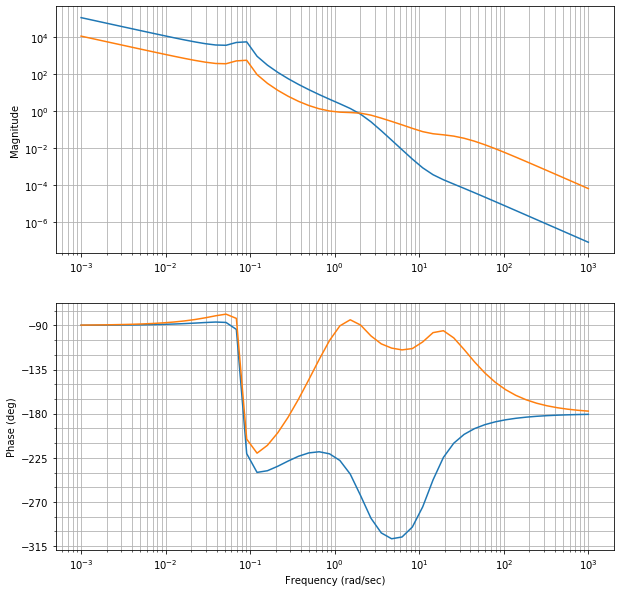

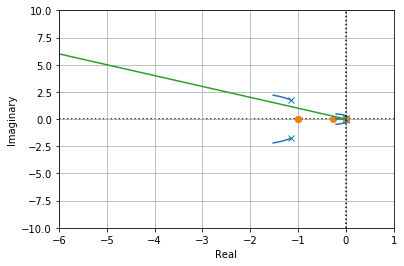

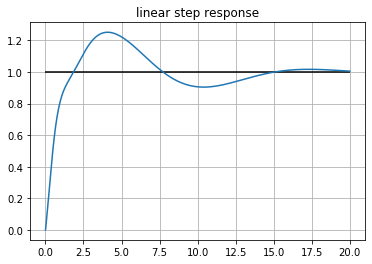

In [4]:
def control_design(operating_point):
    op = operating_point
    G = clean_transfer_function(
        op['ss'].A, op['ss'].B,
        op['ss'].C, op['ss'].D,
        op['u_id']['thrtl'], op['y_id']['h'])

    s = control.tf([1, 0], [0, 1])
    H = 0.1*(20*(s+1)/(s+20))**3#-0.17*(s+1)**3*(20/(s+20))**3
    plt.figure(figsize=(10, 10))
    control.bode([G, G*H]);

    control.rlocus(G*H, xlim=[-6, 1], ylim=[-10, 10], kvect=np.linspace(0, 1, 1000));
    plt.plot([0, -10], [0, 10])
    plt.grid()
    
    plt.figure()
    t, y = control.step_response(control.feedback(G*H),
        T = np.linspace(0, 20, 1000))
    plt.hlines(1, t[0], t[-1])
    plt.plot(t, y)
    plt.grid()
    plt.title('linear step response')

    return {
        'H': H
    }

control_data = control_design(operating_point)

In [5]:
class DiscreteStateSpace:
  """
  Use this class to implement any controller you need.
  It takes a continuous time transfer function.
  """
  
  def __init__(self, H, dt):
    sys = control.tf2ss(control.c2d(H, dt))
    self.x = np.zeros((sys.A.shape[0], 1))
    self.A = sys.A
    self.B = sys.B
    self.C = sys.C
    self.D = sys.D
    self.dt = sys.dt

  def update(self, u):
    self.x = self.A.dot(self.x) + self.B.dot(u)
    return self.C.dot(self.x) + self.D.dot(u)
 
  def __repr__(self):
    return repr(self.__dict__)

x0 [5.00000000e+02 1.02683508e-02 1.02683508e-02 0.00000000e+00
 1.00000000e+02 0.00000000e+00]
u0 [0.29206122 2.44908588 0.25       0.        ]
[500, 0.0102684, 0.0102684, 2.82028e-11, 100, 10000]


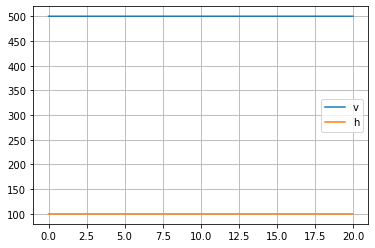

In [6]:
def simulate(control_data, operating_point):
    op = operating_point
    x_id = op['x_id']
    y_id = op['y_id']
    u_id = op['u_id']
    H = control_data['H']
    x_sym = ca.SX.sym('x', 6, 1)
    u_sym = ca.SX.sym('u', 4, 1)
    dt = 0.01
    controller = DiscreteStateSpace(H, dt)

    # Construct a Function that integrates over 4s
    x = op['x0']
    print('x0', op['x0'])
    print('u0', op['u0'])
    h = []
    data = {
        'v': [],
        'alpha': [],
        'theta': [],
        'q': [],
        'h': [],
        'pos': [],
        't': [],
    }
    t = 0
    tf = 20
    h_desired = 200
    v_desired = 500
    while t < tf:
        h_error = h_desired - x[x_id['h']]
        v_error = v_desired - x[y_id['v']]
        u = np.array(op['u0'])
        #u[u_id['thrtl']] += 1*h_error
        #u[u_id['thrtl']] += controller.update(h_error)
        F = ca.integrator('F','cvodes',{
            'x': x_sym, 'ode': transp(0, x_sym, u)},{'tf': dt})
        res = F(x0=x)
        x = res['xf']
        data['v'].append(x[x_id['v']])
        data['alpha'].append(x[x_id['alpha']])
        data['theta'].append(x[x_id['theta']])
        data['q'].append(x[x_id['q']])
        data['h'].append(x[x_id['h']])
        data['pos'].append(x[x_id['pos']])
        data['t'].append(t)
        t += dt
    for k in data.keys():
        data[k] = np.array(data[k])
    print(x)
    return data

data = simulate(control_data, operating_point)
plt.plot(data['t'], data['v'], label='v');
plt.plot(data['t'], data['h'], label='h');
plt.legend(loc='best')
plt.grid()